# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
from DYNASMART_Process import *
import DYNASMART_Process as dy
import AV_functions as av
from gurobipy import *
import datetime
import requests

In [3]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
# personData=pd.read_csv('input/personData_1.csv')
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
#Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

### Basic Statistics

In [3]:
traveler_trips.head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,driver_passenger_flag,joint_trip_flag,park&ride_flag,starttimeinterval,starttime,hh_id,origin_node,destination_node,Diff_bet_starttime,travel_time
0,8600957,11,0.1164,1,24.0,1,Home,Shop,1,1,...,1,0,0,1,1.0,2744264,9737,10716,30.0,6.0
1,8600957,11,0.1164,2,32.0,3,Shop,eatingout,62,16,...,1,0,0,1,31.0,2744264,10716,10057,37.0,5.0
2,8600957,11,0.1164,3,39.0,1,eatingout,Maintenance,20,5,...,1,0,0,1,68.0,2744264,10021,9674,41.0,2.0
3,8600957,11,0.1164,4,198.0,3,Maintenance,Home,3,1,...,1,0,0,1,109.0,2744264,9737,9675,199.0,1.0
4,8600957,11,0.1164,5,191.0,1,Home,work,1,1,...,1,0,0,8,308.0,2744264,9673,9736,192.0,1.0


In [4]:
traveler_trips.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time'],
      dtype='object')

In [5]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

Number of household: 	 32472
Number of traveler: 	 76499
Number of trips: 	 382158
Number of indiv trip: 	 333264
Number of joint trip: 	 48894


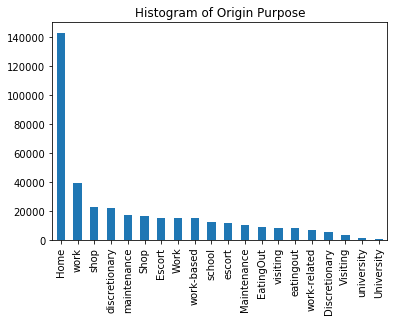

In [6]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

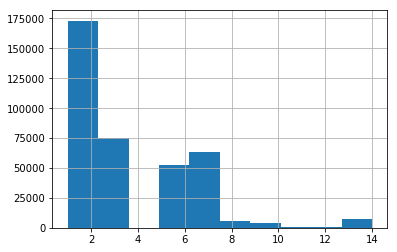

In [7]:
traveler_trips.tripmode.hist()

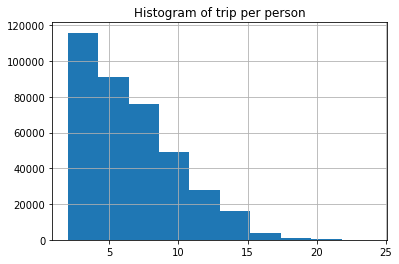

In [8]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

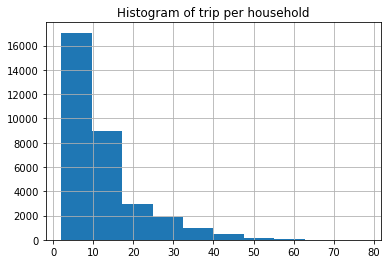

In [9]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

In [10]:
def identify_indiv_trip_before_jointtrip(traveler_trips):
    before_joint_trip=pd.DataFrame()
    for traveler in traveler_trips.person_id.unique():
#         print(traveler,len(traveler_trips[traveler_trips.person_id==traveler])-1)
        for index in range(len(traveler_trips[traveler_trips.person_id==traveler])-1):
#             if(traveler==5982639):
#                 print(traveler,index,(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0),(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1)) 
            if (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0) & (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1):  
#                 print(traveler,index)
                before_joint_trip=before_joint_trip.append(traveler_trips[traveler_trips.person_id==traveler].iloc[index])
    check_joint_trip=traveler_trips.loc[(traveler_trips['joint_trip_flag']==1) & (traveler_trips.trip_counter>2)]
    
#     if (len(check_joint_trip)/2 != len(before_joint_trip)):
#         print(traveler_trips.hh_id.unique(),len(check_joint_trip)/2, len(before_joint_trip))
    return before_joint_trip

In [11]:
# num_ind_trip=[]
# for hh in traveler_trips.hh_id.unique():
#     target_hh=traveler_trips[traveler_trips.hh_id==hh]
#     num_ind_trip.extend([len(identify_indiv_trip_before_jointtrip(target_hh))])

### Draw the sub-area network

C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

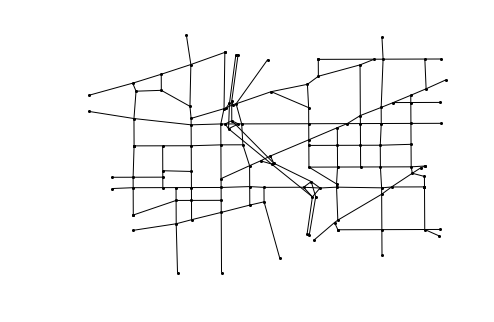

In [12]:
cluster_highlight([])

### Sample Household
Select household 2105189 for intial analysis

C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

10
9
4
7


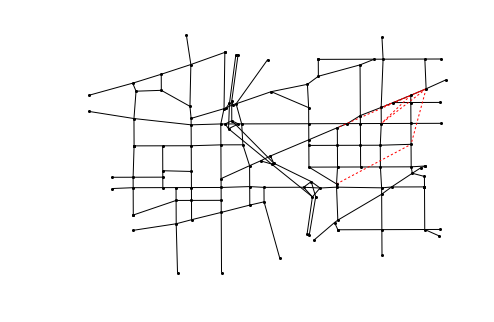

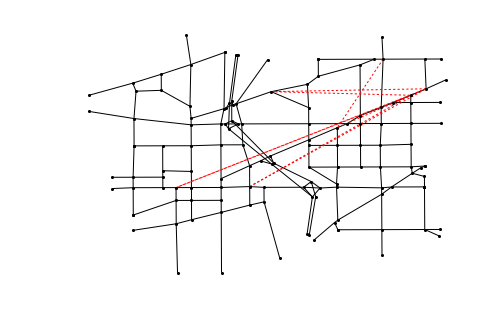

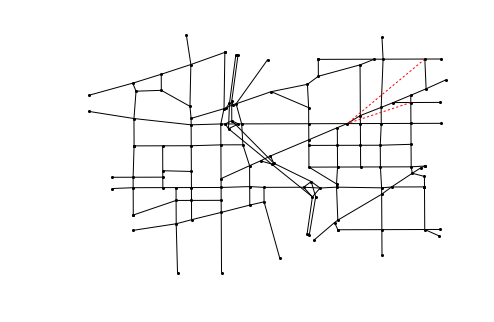

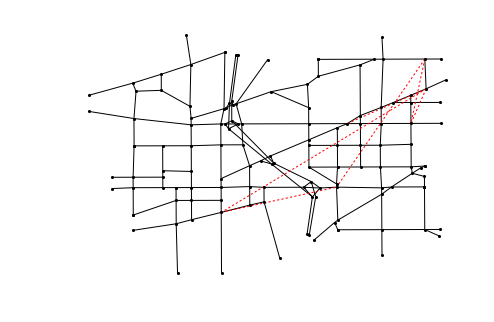

In [13]:
target_hh_id=2105189
people_in_hh=traveler_trips[traveler_trips['hh_id']==2105189]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

In [14]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

In [15]:
# target_hh_id=2105189
# hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
# # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
# num_hh_member=hh_members.size

# target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# sorted_trips=target_hh.sort_values("starttime")
# hh_num_trips=sorted_trips.shape[0]
# sorted_trips["hh_index"]=(range(hh_num_trips))
# R=np.ones(hh_num_trips+1)*15
# #Calculate the distance matrix between all node pairs
# np.random.seed(1)
# C=np.random.rand(2*hh_num_trips+2,2*hh_num_trips+2)*10
# visit_candidate=[sorted_trips['origin_node'].iloc[0]]
# visit_candidate.extend(sorted_trips['origin_node'].tolist())
# visit_candidate.extend(sorted_trips['destination_node'].tolist())
# visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
# # C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)
# c=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)

#### Solve with heuristic

In [16]:
# #Solve with heuristic
# ############################
# #Construct initial feasible solution
# def initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate):
#     #First start with the earlist trip and add the next trip whenever possible
#     #########################
#     #Sort all household trips by time
#     trip_list=[]
#     last_start_time=0
#     last_dest_index=0
#     last_travel_time=0 #The travel time between the OD of same trip
#     trip_list=[]
#     index=0
#     for index1,trip in sorted_trips.iterrows():
#         #If it does not violate the time constraint then add the trip to the route
#         current_travel_time=C[last_dest_index,index+1] #The travel time between the orig of #current trip and the dest of last trip
#         print(trip['starttime'],'\t',index+1,'\t',last_dest_index,'\t',last_travel_time,'\t',last_start_time,'\t',current_travel_time)
#         if trip['starttime']>last_travel_time+last_start_time+current_travel_time:
#             trip_list.extend([trip['hh_index']])
#             last_start_time=trip['starttime']
#             last_dest_index=index+1+hh_num_trips
#             last_travel_time=C[index+1,index+1+hh_num_trips]
#             print(last_dest_index,index+1,trip['hh_index'])
#         index+=1
#     return trip_list

In [17]:
# i=0
# num_optimization=0
# num_conflict_trips={}
# last_time=datetime.datetime.now()
# for target_hh_id in [2105189]: #traveler_trips['hh_id'].unique():
# #     hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
#     # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
#     num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
#     target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
#     sorted_trips=target_hh.sort_values("starttime")
#     hh_num_trips=sorted_trips.shape[0]
#     sorted_trips["hh_index"]=(range(hh_num_trips))
#     C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
#     visit_candidate=[sorted_trips['origin_node'].iloc[0]]
#     visit_candidate.extend(sorted_trips['origin_node'].tolist())
#     visit_candidate.extend(sorted_trips['destination_node'].tolist())
#     visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
#     C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
# #     C=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)
#     route=initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate)
#     i=i+1
#     if len(route)!=hh_num_trips:
#         num_optimization=num_optimization+1
#         if (hh_num_trips-len(route)) in num_conflict_trips:
#             num_conflict_trips[hh_num_trips-len(route)]=num_conflict_trips[hh_num_trips-len(route)]+1
#         else:
#             num_conflict_trips[hh_num_trips-len(route)]=1
#     if (i%1000==0):
#         print(i,target_hh_id,num_optimization,datetime.datetime.now()-last_time)
# #         last_time=datetime.datetime.now()

## Extract the distance information with Google API

In [18]:
# #Derive the travel time matrix from google api
# origin_node=[]
# destination_node=[]
# travel_time=[]
# k=0
# for i in nodexy:
#     print(k)
#     k=k+1
#     for j in nodexy:
#         origin_node.extend([i])
#         destination_node.extend([j])
#         travel_time.extend([travel_time_between_nodes(int(i),int(j),nodexy)])

## Solve the optimization with Gurobi

In [19]:
def extract_hh_information(target_hh_id,traveler_trips):
    '''
    Get the household related information. Those information will be used as input
    for the optimization model
    '''
    num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
    target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
    sorted_trips=target_hh.sort_values("starttime")
    hh_num_trips=sorted_trips.shape[0]
    sorted_trips["hh_index"]=(range(hh_num_trips))
    C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate=[sorted_trips['origin_node'].iloc[0]]
    visit_candidate.extend(sorted_trips['origin_node'].tolist())
    visit_candidate.extend(sorted_trips['destination_node'].tolist())
    visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
    C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
    
    visit_candidate_zone=[sorted_trips['orig_maz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_maz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_maz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_maz'].iloc[0]])
    
    expected_arrival_time=np.ones(2*hh_num_trips+2)
    expected_arrival_time[0]=traveler_trips[traveler_trips['hh_id']==target_hh_id]['starttime'].min()-1
    expected_arrival_time[1:hh_num_trips+1]=sorted_trips.starttime
    for i in range(1+hh_num_trips,2*hh_num_trips+2):
       
        expected_arrival_time[i]=expected_arrival_time  [i-hh_num_trips]+C[i-hh_num_trips,i]
#         print(i,i-hh_num_trips,hh_num_trips,expected_arrival_time[i-hh_num_trips],expected_arrival_time[i],C[i-hh_num_trips,i])
    expected_arrival_time[2*hh_num_trips+1]=1440
    early_penalty=10*np.ones(2*hh_num_trips+2)
    late_penalty=10*np.ones(2*hh_num_trips+2)
    return num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,visit_candidate_zone

def dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,output_flag):
    m1=Model("AVSchedule")
    x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
    T=m1.addVars(2*hh_num_trips+2,name="T")
    S=m1.addVars(2*hh_num_trips+2,name="S")
    R=np.ones(hh_num_trips+1)*150
    # B=traveler_trips[traveler_trips['hh_id']==household]['starttime'].max()-traveler_trips[traveler_trips['hh_id']==household]['starttime'].min()
    B=1440
    #Add constraints
    ###################################
    #Basic deliver and pickup constraints
    # m1.addConstrs((x[0,i]==1 for i in range(1,2)),"adf")
    m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
    m1.addConstrs((x.sum('*',i)==1 for i in [2*hh_num_trips+1]),"ToDepot3") 
    m1.addConstrs((x.sum(i,"*")==x.sum("*",i+hh_num_trips) for i in range(1,hh_num_trips+1)),"DemandbeDelivered11")
    m1.addConstrs((x.sum(i,"*")<=1 for i in range(2*hh_num_trips+1)),"PickupOnce12")
    m1.addConstrs((x.sum("*",j)<=1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")
    m1.addConstrs((x.sum("*",i)==x.sum(i,"*") for i in range(1,2*hh_num_trips+1)),"FlowConvervative14")
    m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)),"NoSamePointCircleVisit")
    # ###################################
    #Time constratins
    # m1.addConstrs((T[i]==expected_arrival_time[i] for i in range(2*hh_num_trips+2)),'ExactStartTime')
    m1.addConstrs((T[j]-T[i]-B*x[i,j]>=C[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
    m1.addConstrs((T[i+hh_num_trips]-T[i]-B*x.sum(i,"*")>=(C[i,i+hh_num_trips]-B) for i in range(1,hh_num_trips+1)),"deliverafterpickup16")

    # ####################################
    # #Late/Early Arrival penalty
    m1.addConstrs((S[i]>=early_penalty[i]*(expected_arrival_time[i]-T[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    m1.addConstrs((S[i]>=late_penalty[i]*(T[i]-expected_arrival_time[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')

    m1.addConstrs(x[i,j]==0 for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2) if expected_arrival_time[j]-expected_arrival_time[i]<-30)
    obj1=sum(x.sum(i,'*')*R[i] for i in range(hh_num_trips+1))
    obj2=S.sum()
    obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
    m1.setObjective(obj1-obj2-obj3, GRB.MAXIMIZE)
    # m1.setObjective(obj1-obj3,GRB.MAXIMIZE)
    m1.setParam(GRB.Param.OutputFlag,output_flag)
    m1.optimize()
    return m1,x

def extract_route_from_model_solution(x,target_hh_id,visit_candidate_zone,hh_num_trips):
    #Check the feasibility of the answer
    route_dic={}
    for i in range(2*hh_num_trips+2):
        for j in range(2*hh_num_trips+2):
            if x[i,j].x>0.91:
                route_dic[i]=j
    route_node=[0]
    route=[visit_candidate_zone[0]]
    for i in range(len(route_dic)):
        route_node.extend([route_dic[route_node[i]]])
        route.extend([visit_candidate_zone[route_node[i+1]]])
    return route
def find_av_schedule_exact_method(target_hh_id,traveler_trips,output_flag):
    num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips)
    m1,x=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,output_flag)
    route=extract_route_from_model_solution(x,target_hh_id,visit_candidate_zone,hh_num_trips)
    return route

In [20]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

In [ ]:
counter=0
routes=[]
for household_id in traveler_trips.hh_id.unique():
    if counter%100==0: 
        print('Estimate Route for the ',counter,'th household')
    counter=counter+1
    if len(traveler_trips[traveler_trips.hh_id==household_id])<30:
        routes.extend(find_av_schedule_exact_method(household_id,traveler_trips,output_flag=0))

Estimate Route for the  0 th household
Estimate Route for the  100 th household
Estimate Route for the  200 th household
Estimate Route for the  300 th household
Estimate Route for the  400 th household


#### Result Analysis

In [ ]:
for v in m1.getVars():
     if (v.x !=0):
        print(v.varName, v.x)        

In [ ]:
#Check the feasibility of the answer
route_dic={}
counter=0
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        if x[i,j].x==1:
            route_dic[i]=j
            counter=counter+1
print("there are ",counter," trips")
route=[0]
for i in range(len(route_dic)):
    route.extend([route_dic[route[i]]])
    print(route[i],route_dic[route[i]] )#,C[route[i],route_dic[route[i]]],T[route[i]])